## PyTorch-AlexNet

**AlexNet** is the name of a CNN, designed by Alex Krizhevsky, Ilya Sutskever and Geoffrey Hinton. **AlexNet** was the first deep neural network which won the imagenet competition and arguably started the modern deep learning revolution. In the notebook below we will explore **AlexNet** architecture.

https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

In [1]:
#Perform imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Import models
from torchvision import models

In [3]:
alexnet = models.alexnet(pretrained=True)

In [4]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Above we can see the layers of **AlexNet**. AlexNet has five Convolutional layers, it has three fully connected layers. After every convolutional layer there is a MaxPool layer. Max. pool layers have a dilation of 1. Dilation is explained here very nicely https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md. 
After the convolutional layers there is an AdaptiveAvgPool2d layer. That is an average pool layer with output size of (6,6). After these layers there are fully connected layers.

In [5]:
#lets count the number of parameters in the model
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
count_parameters(alexnet)

 23232
    64
307200
   192
663552
   384
884736
   256
589824
   256
37748736
  4096
16777216
  4096
4096000
  1000
______
61100840


There are 61 million parameters in the model.

In [6]:
#Lets implement AlexNet model from scratch
class AlexNetClone(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 11, 4, 2) 
        self.conv2 = nn.Conv2d(64, 192, 5, 1, 2)
        self.conv3 = nn.Conv2d(192, 384, 3, 1, 1)
        self.conv4 = nn.Conv2d(384, 256, 3, 1, 1)
        self.conv5 = nn.Conv2d(256, 256, 3, 1, 1)
        
        
        self.fc1 = nn.Linear(9216,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,1000)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        X = F.relu(self.conv3(X))
        X = F.relu(self.conv4(X))
        X = F.relu(self.conv5(X))
        X = F.max_pool2d(X, kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        X = F.AdaptiveAvgPool2d(X, output_size=(6, 6))
        
        X = X.view(-1, 9216)
        X = F.dropout(X, p=0.5)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, p=0.5)
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [7]:
alexNetClone = AlexNetClone()
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
count_parameters(alexNetClone)

 23232
    64
307200
   192
663552
   384
884736
   256
589824
   256
37748736
  4096
16777216
  4096
4096000
  1000
______
61100840


Our AlexnetClone exactly matches PyTorch's AlexNet.

### Lets apply **AlexNet** on **CIFAR-10** dataset

In [8]:
#Download the dataset and transform them to the format for AlexNet
train_transform = transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

train_data = datasets.CIFAR10(root='./', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='./', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [10]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [11]:
#Create dataloaders
torch.manual_seed(101)  # for reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [12]:
#Lets update the classification layer of AlexNet to take in CIFAR-10 dataset
for param in alexnet.parameters():
    param.requires_grad = False

In [13]:
torch.manual_seed(42)
alexnet.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(1024, 10),
                                 nn.LogSoftmax(dim=1))

In [14]:
#Count parameters
count_parameters(alexnet)

9437184
  1024
 10240
    10
______
9448458


Parameters to train are much less than the full AlexNet

In [15]:
#Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.classifier.parameters(), lr=0.001)

In [16]:
train_data[0][0].shape

torch.Size([3, 224, 224])

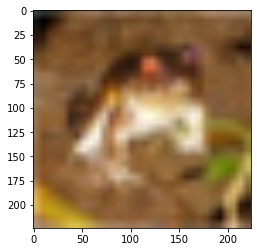

In [17]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(train_data[0][0])
plt.imshow(np.transpose(im_inv, (1,2,0)))

CIFAR-10 are very low resolution images. Very different from the images on which AlexNet is trained on. Lets see how AlexNet performs on them.

In [20]:
#Lets train the model
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = alexnet(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = alexnet(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 1.47238207  accuracy:  69.900%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.80869359  accuracy:  69.325%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.49031729  accuracy:  69.033%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.95140779  accuracy:  69.025%
epoch:  1  batch:  200 [  2000/8000]  loss: 1.01253569  accuracy:  70.450%
epoch:  1  batch:  400 [  4000/8000]  loss: 1.60712171  accuracy:  71.000%
epoch:  1  batch:  600 [  6000/8000]  loss: 1.09018540  accuracy:  71.000%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.95663863  accuracy:  71.013%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.31028634  accuracy:  73.950%
epoch:  2  batch:  400 [  4000/8000]  loss: 1.14042544  accuracy:  73.425%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.73659503  accuracy:  73.383%
epoch:  2  batch:  800 [  8000/8000]  loss: 1.25582957  accuracy:  73.112%

Duration: 1514 seconds


In [21]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(1882), tensor(2098), tensor(2069)]
Test accuracy: 68.967%
